In [23]:
## import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys
import meep as mp
import numpy as np

#setup some constants and parameters
M=2**21
tsim=7e-12
eps0 = 8.854187e-12
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12
deltap = np.sqrt(1/3/eps0/hbar/c)*kb
T=30000
frq_min = 0
frq_max = 1.25*25/12
nfreq = 1000
fcen = (frq_min + frq_max)/2
df = frq_max - frq_min
dfp = 1/2
#define square root of Dn function
def Dnsqt(wla,T):
    return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)

#generate an array of the square root of Dn function
Dsqt = []
for n in range(1,M):
    Dsqt.append(Dnsqt(2*np.pi*n/tsim,T))

#define how many times to run to average the results
Ncomp= 10
nfreq =  16000
#define the starting sum of the result
Efsum = np.zeros(nfreq)
Ens = np.zeros(2*22)
resolution = 10
dA = 1
dB = 0.02
dpml = 1.0
sz = dpml*2+dA*2+dB
cell = mp.Vector3(0, 0, sz)
pml_layers = [mp.PML(dpml)]



for i in range(Ncomp):
    
    #generate random numbers
    M0 = np.random.normal(0,1)
    Mlp = np.random.normal(0,1,M-1)
    Nlp = np.random.normal(0,1,M-1)
    MM = np.random.normal(0,1)
    
    #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
    #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
    #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
    Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
    Eflp = np.multiply((Mlp + 1j*Nlp), Dsqt)
    Eflm = np.flip(np.conjugate(Eflp))
    EfM = np.array([MM*Dnsqt(2*np.pi*M/tsim,T)])
    Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
    #we normalize Ef and compute its inverse fast fourier transform
    Efn = deltap*T/np.sqrt(tsim)*Ef
    En = np.fft.ifft(Efn)
    
    
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('a'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)
    def source(t):
        f = int(t*200)
        return En[f]

    sources = [mp.Source(mp.CustomSource(src_func=source),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,-0.5*sz+dpml),
                     #amplitude = 10
                     )]
    def BlockAB(N, center):
        geometry = []
        for i in range(N):
            geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dA),
                     center=mp.Vector3(z=0-dA/2-dB/2),
                     material=mp.Medium(epsilon=1)))
            geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dB),
                     center=mp.Vector3(z=0),
                     material=mp.Medium(epsilon=36)))
            geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dA),
                     center=mp.Vector3(z=dB/2+dA/2),
                     material=mp.Medium(epsilon=1)))
        geometry = geometry.tolist()
        return geometry
    sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    dimensions = 1,
                    Courant = 1,
                    resolution=resolution,
                    geometry=BlockAB(1,0))
    

    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(0,0,0))
    tran = sim.add_flux(fcen, df, nfreq, tran_fr)
    
    
    sim.run(until=2100)

    tran_flux = mp.get_fluxes(tran)
    flux_freqs = mp.get_flux_freqs(tran)
    Ts = []
    fs = []
    for i in range(nfreq):
        fs = np.append(fs,flux_freqs[i])
        Ts = np.append(Ts,tran_flux[i])    
    Efsum += Ts
    
    
    

#average the final result
Efavg = Efsum/Ncomp

#save data to some file or reload file to write more data on it



[                    ] 0%

-----------
Initializing structure...
time for choose_chunkdivision = 0.00146294 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 4.02 with resolution 1000
     block, center = (0,0,-0.51)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0)
          size (1e+20,1e+20,0.02)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (36,36,36)
     block, center = (0,0,0.51)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.00494599 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2100.0)

Meep progress: 7.995/2100.0 = 0.4% done in 4.0s, 1046.7s to go
on time step 7999 (time=7.999), 0.000500064 s/step



KeyboardInterrupt



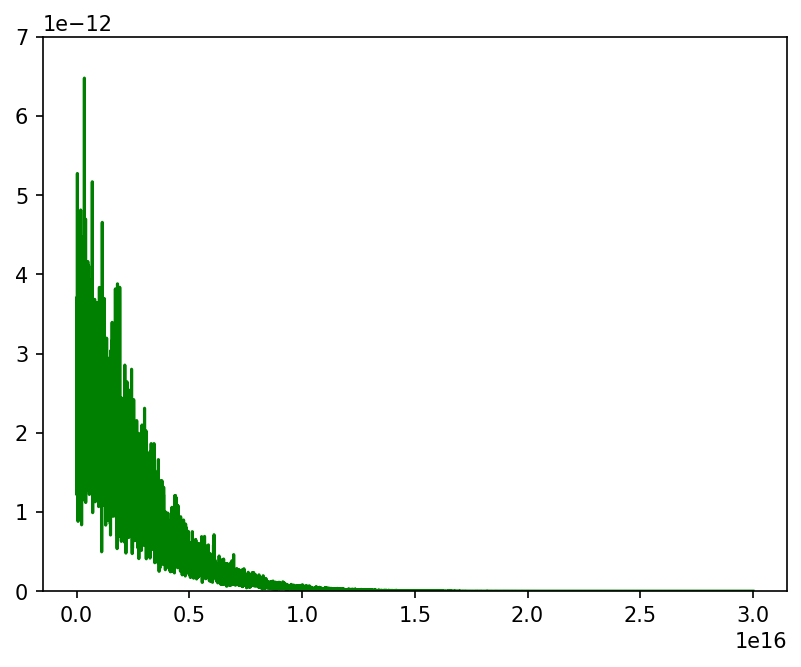

In [21]:
plt.figure(dpi=150)
freqs = np.linspace(0,30e15,16000)
plt.plot(freqs,Efavg,'g')
#plt.xlim(0,5e15)
plt.ylim(0,7e-12)
plt.savefig('test_detector_photonic_crystal_30000.png')
plt.show()

#np.savez("test_custom_source_photonic_crystal_30000.npz", Efavg_30000 = Efavg)

In [18]:
from PIL import Image

def transPNG(srcImageName, dstImageName):
    img = Image.open(srcImageName)
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = list()
    for item in datas:
        if item[0] > 225 and item[1] > 225 and item[2] > 225:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
            
    img.putdata(newData)
    img.save(dstImageName, "PNG")
transPNG('test_detector_photonic_crystal_30000.png','trans_test_detector_photonic_crystal_30000.png')